In [39]:
import gurobipy as gp
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
#problem 1-3

In [29]:
#read in the dataset
roi_1 = pd.read_csv("roi_company1.csv")
#create model
roi_1_model = gp.Model()

#create decision variables
x = {}
for i, row in roi_1.iterrows():
    platform = row['Platform']
    tier = row['Tier']
    #adding one decision variable for each platform & tier with it's lower and upper bound
    x[(platform, tier)] = roi_1_model.addVar(
        lb =0,
        ub = (row['UpperBound'] - row['LowerBound']), #addresses non-increasing function and tiered structure
        name = f"{platform}_{tier}",
        vtype='C'
    )

#objective function
#maximize roi
roi_1_model.setObjective(gp.quicksum(row['ROI'] * x[(row['Platform'], row['Tier'])] for _, row in roi_1.iterrows()),sense=gp.GRB.MAXIMIZE)


#setting constraints
#budget of 10 million
roi_1_model.addConstr(gp.quicksum(x[v] for v in x) <= 10)

#Print Tv vs. Facebook Email
roi_1_model.addConstr(gp.quicksum(x[v] for v in x if v[0] in ['Print', 'TV']) <=
                     gp.quicksum(x[v] for v in x if v[0] in ['Facebook', 'Email']))
#social media vs. seo and adwords
roi_1_model.addConstr(gp.quicksum(x[v] for v in x if v[0] in ['Facebook', 'LinkedIn', 'Instagram', 'Snapchat', 'Twitter']) >=
                     2 * gp.quicksum(x[v] for v in x if v[0] in ['SEO', 'AdWords']))

#no more than 3 million
for platform in roi_1['Platform'].unique():
    roi_1_model.addConstr(
        gp.quicksum(x[v] for v in x if v[0] == platform) <= 3
    )

In [33]:

roi_1_model.Params.OutputFlag = 0 # tell gurobi to shut up!!
roi_1_model.optimize()
print(roi_1_model.objVal)
print(roi_1_model.X)

0.54364
[0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.9999999999999996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9, 0.10000000000000009, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0]


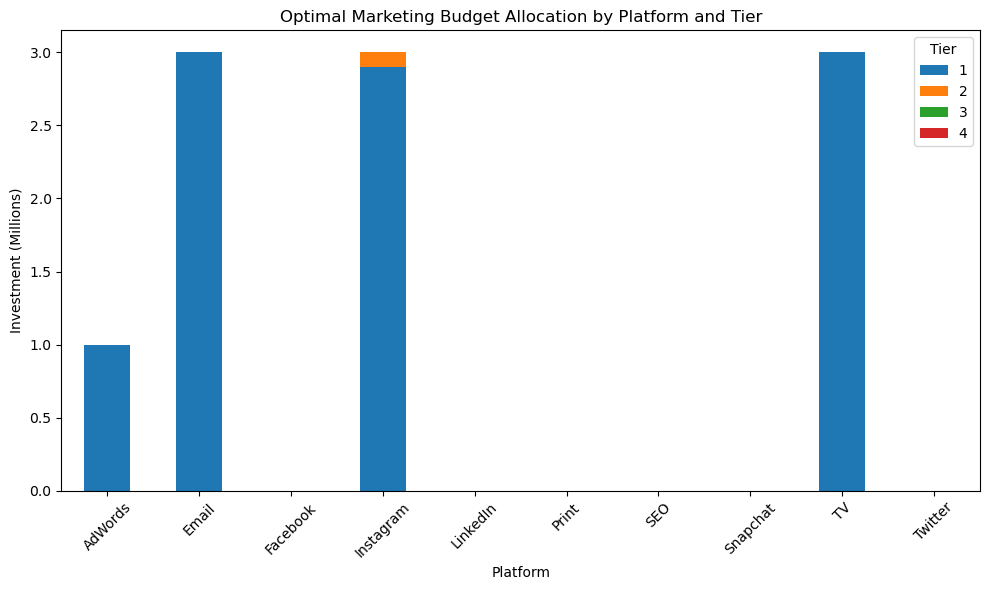

In [38]:
#a visual for the decision variable allocation
results = []
for v in roi_1_model.getVars():
    results.append({
        'Variable': v.VarName,
        'Value': v.X  # This is the optimized investment amount
    })

results_df = pd.DataFrame(results)

results_df[['Platform', 'Tier']] = results_df['Variable'].str.split('_', expand=True)
results_df['Tier'] = results_df['Tier'].astype(int)


pivot_df = results_df.pivot(index='Tier', columns='Platform', values='Value').fillna(0)

pivot_df.T.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Optimal Marketing Budget Allocation by Platform and Tier")
plt.xlabel("Platform")
plt.ylabel("Investment (Millions)")
plt.legend(title="Tier")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [62]:
#problem 7

roi = pd.read_csv("roi_monthly.csv")
min_amt = pd.read_csv("min_amount.csv")

months = roi['Month'].unique()
platforms = roi['Platform'].unique()

# ROI dictionary (Month,Platform,Tier) -> ROI
roi_dict = {(r.Month, r.Platform, r.Tier): r.ROI for _, r in roi.iterrows()}

# Min investment per platform (platform-level)
min_dict = {r.Platform: r.MinInvestment for _, r in min_amt.iterrows()}

# Determine tiers per platform (keeps original labels)
tiers_per_platform = {
    p: sorted(roi[roi['Platform'] == p]['Tier'].unique())
    for p in platforms
}

# --- Determine tier capacities (cap[(p,k)] = amount required to "fill" that tier) ---
cap = {}
for _, r in roi.iterrows():
    p = r.Platform
    k = r.Tier
    lb = float(r.LowerBoundM)
    ub = r.UpperBoundM
    if ub == float('inf') or (isinstance(ub, str) and ub.lower() == 'inf'):
        # If infinite upper bound, cap it at platform maximum (3M) minus lower bound
        cap_amt = max(0.0, 3.0 - lb)
    else:
        cap_amt = max(0.0, float(ub) - float(lb)) 
    cap[(p, k)] = cap_amt

# --- Initialize model ---
m = gp.Model()

# Decision vars: continuous x for spend per (t,p,k)
valid_tpk = [(t,p,k) for t in months for p in platforms for k in tiers_per_platform[p]]
x = m.addVars(valid_tpk, lb=0.0, name="x")

# Binary y indicating tier is fully filled (1) or not (0)
y = m.addVars(valid_tpk, vtype=gp.GRB.BINARY, name="y_full")

# Monthly budgets and returns
B = m.addVars(months, lb=0.0, name="B")
R = m.addVars(months, lb=0.0, name="R")

# Initial budget 
m.addConstr(B[months[0]] == 10)

# --- Constraints ---
#for each month
for t_idx, t in enumerate(months):
    # Monthly return: sum ROI * spend  (ROI should be in decimal, e.g., 0.04 for 4%)
    m.addConstr(
        R[t] == gp.quicksum(roi_dict.get((t,p,k), 0.0) * x[(t,p,k)]
                            for p in platforms for k in tiers_per_platform[p] ),
        name=f"return_def_{t}"
    )

    # Budget usage
    m.addConstr(
        gp.quicksum( x[(t,p,k)] for p in platforms for k in tiers_per_platform[p] ) <= B[t],
        name=f"budget_use_{t}"
    )

    # Per-platform rules
    for p in platforms:
        tiers_p = tiers_per_platform[p]

        # platform-level min enforcement (either 0 or >= min) using an auxiliary binary z if desired.
        z = m.addVar(vtype=gp.GRB.BINARY, name=f"z_active_{t}_{p}")
        total_spend_p = gp.quicksum(x[(t,p,k)] for k in tiers_p)
        min_amt_p = min_dict.get(p, 0.0)
        m.addConstr(total_spend_p >= min_amt_p * z, name=f"min_platform_{t}_{p}")
        m.addConstr(total_spend_p <= 3 * z, name=f"cap_platform_onoff_{t}_{p}")

        # Now per-tier caps and full-fill logic:
        for i, k in enumerate(tiers_p):
            cap_pk = cap.get((p,k), 3)   # dollars
            # 1) Tier cannot exceed its cap
            m.addConstr(x[(t,p,k)] <= cap_pk, name=f"cap_tier_{t}_{p}_{k}")
            # 2) If y=1 then x >= cap (fully filled). If y=0, x can be any [0,cap]
            m.addConstr(x[(t,p,k)] >= cap_pk * y[(t,p,k)], name=f"full_if_y_{t}_{p}_{k}")

            # 3) Dependence: to allow any money in tier k (k>first), previous tier must be fully filled.
            if i > 0:
                prev_k = tiers_p[i-1]
                # This enforces: x_{k} <= cap_k * y_{prev}, i.e., x_k = 0 unless previous full.
                m.addConstr(x[(t,p,k)] <= cap_pk * y[(t,p,prev_k)], name=f"dep_{t}_{p}_{k}")

    # Cross-platform constraints (safe-guard: only apply if platforms exist)
    if all(p in platforms for p in ["Print","TV","Facebook","Email"]):
        m.addConstr(
            gp.quicksum(x[(t,p,k)] for p in ["Print","TV"] for k in tiers_per_platform[p]) <=
            gp.quicksum(x[(t,p,k)] for p in ["Facebook","Email"] for k in tiers_per_platform[p]),
            name=f"print_tv_le_fb_email_{t}"
        )

    social_list = [p for p in ["Facebook","LinkedIn","Instagram","Snapchat","Twitter"] if p in platforms]
    search_list = [p for p in ["SEO","AdWords"] if p in platforms]
    if social_list and search_list:
        m.addConstr(
            gp.quicksum(x[(t,p,k)] for p in social_list for k in tiers_per_platform[p]) >=
            2.0 * gp.quicksum(x[(t,p,k)] for p in search_list for k in tiers_per_platform[p]),
            name=f"social_ge_2x_paid_{t}"
        )

    # Budget update (reinvest half of dollar return)
    if t_idx < len(months)-1:
        next_t = months[t_idx+1]
        m.addConstr(B[next_t] == B[t] + 0.5 * R[t], name=f"budget_update_{t}_to_{next_t}")

# Objective: maximize total return (sum of dollar returns)
m.setObjective(gp.quicksum(R[t] for t in months), gp.GRB.MAXIMIZE)

# --- Solve ---
m.optimize()
m.Params.OutputFlag = 0

# --- Output for inspection ---
print("\nStatus:", m.Status)
for t in months:
    print(f"\nMonth: {t}")
    print(f"  Budget: {B[t].X:,.2f}")
    print(f"  Return: {R[t].X:,.2f}")
    print("  Platform spends:")
    for p in platforms:
        s = sum(x[(t,p,k)].X for k in tiers_per_platform[p])
        if s > 0:
            print(f"    {p}: {s:,.2f}")

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1620 rows, 1104 columns and 4404 nonzeros
Model fingerprint: 0x4a831f3f
Variable types: 504 continuous, 600 integer (600 binary)
Coefficient statistics:
  Matrix range     [5e-03, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 1e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 1118 rows and 627 columns
Presolve time: 0.01s
Presolved: 502 rows, 477 columns, 1992 nonzeros
Variable types: 249 continuous, 228 integer (228 binary)

Root relaxation: objective 7.154698e+00, 376 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    7.15470    0   10   -0.00000    7.